In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 96
import numpy as np
import pandas as pd
import seaborn as sns

# import libraries for biological data analysis
from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting



import warnings
warnings.filterwarnings('ignore')


### CTCF peaks from chip-seq

In [2]:
ctcf = bioframe.read_table('/project/fudenber_735/yxiao977/frip_sm_data/ChIP_fastqs_maps/Justice_2020_mm10/SRR10099910/SRR10099910.q30.mm10.sort_peaks.narrowPeak', schema='bed')
ctcf['mid']=(ctcf.end+ctcf.start)/2

### ctcf from JASPAR data

In [3]:
direct='/project/fudenber_735/motifs/mm10/jaspar/MA0139.1.tsv.gz'
motif=bioframe.read_table(direct)
motif.head()
motif=motif.rename(columns={0: 'chrom', 1: 'start',2:'end',3:'name',4:'score',5:'pval',6:'strand'})

### overlap

In [4]:
peaks_motifs = bioframe.overlap(ctcf,motif,how='inner')
peaks_motifs = peaks_motifs[(peaks_motifs['chrom']!= 'chrX')&(peaks_motifs['chrom']!= 'chrY')]

In [5]:
peaks_motifs=peaks_motifs.rename(columns={'strand':'strand_','strand_':'strand'})
peaks_motifs=peaks_motifs[['chrom','start','end','name','score','mid', 'strand']]

### binning the sites

In [6]:
peaks_motifs_cluster = bioframe.cluster(peaks_motifs, min_dist=10000)#

In [7]:
# Group by 'chuster_start' and 'cluster_end' and get the index of rows with the max 'score' within each group
idx = peaks_motifs_cluster.groupby(['cluster_start', 'cluster_end'])['score'].idxmax()

# Filter the dataframe to keep only the rows with the max 'score' in each group
peaks_motifs_bin_s = peaks_motifs_cluster.loc[idx].reset_index(drop=True)

peaks_motifs_bin_s


,chrom,start,end,name,score,mid,strand,cluster,cluster_start,cluster_end
0,chrM,50,1684,SRR10099910.q30.mm10.sort_peak_48675,146,867.0,-,29985,50,1684
1,chr18,3005726,3005978,SRR10099910.q30.mm10.sort_peak_21060,515,3005852.0,-,13137,3005726,3005978
2,chr18,3039488,3039650,SRR10099910.q30.mm10.sort_peak_21061,65,3039569.0,-,13138,3039488,3039650
3,chr14,3050178,3050329,SRR10099910.q30.mm10.sort_peak_13317,95,3050253.5,-,8283,3050178,3050329
4,chr4,3052367,3052649,SRR10099910.q30.mm10.sort_peak_30167,210,3052508.0,+,18804,3052367,3052649
...,...,...,...,...,...,...,...,...,...,...
29981,chr1,194879563,194879893,SRR10099910.q30.mm10.sort_peak_3195,894,194879728.0,+,2082,194879563,194879893
29982,chr1,194962248,194962539,SRR10099910.q30.mm10.sort_peak_3198,478,194962393.5,-,2083,194952981,194962539
29983,chr1,194976166,194976743,SRR10099910.q30.mm10.sort_peak_3199,596,194976454.5,+,2084,194976166,194976743
29984,chr1,195040477,195040747,SRR10099910.q30.mm10.sort_peak_3200,553,195040612.0,+,2085,195040477,195040747


### loading Hi-C data, Bonev 2017

In [8]:
# high-resolution reprocessed publically-available data from Bonev et al. 2017
res = 10_000
bonev_file = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES.mm10.mapq_30.1000.mcool'
bonev_cooler = cooler.Cooler(bonev_file+'::resolutions/'+str(res))
view_df_bonev = cooltools.lib.make_cooler_view(bonev_cooler)[:19]

### loading data, Liu_deWit

In [9]:
# data from Liu& deWit et al. 
prefix_dir_liu = '/project/fudenber_735/GEO/liu_deWit_GSE181848/'
cooler_prefix_liu = prefix_dir_liu
sample_dict_liu ={
    'Wapl-0h':'GSM5512837_HiC.01_WAPL_0h.mcool',
    'Wapl-6h':'GSM5512838_HiC.02_WAPL_6h.mcool'
}
sample='Wapl-6h'
mcool_path_liu =  cooler_prefix_liu + sample_dict_liu[sample]
liu_cooler = cooler.Cooler(mcool_path_liu+'::resolutions/'+str(res))
view_df_liu = cooltools.lib.make_cooler_view(liu_cooler)[:19]

In [10]:
# data from Liu 2021
prefix_dir_liu_new = '/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/distiller-mm10/results/coolers_library/'
cooler_prefix_liu_new = prefix_dir_liu_new
sample_dict_liu_new ={
    'Wapl-0h_new':'liu_wapl0h.mm10.mapq_30.1000.mcool',
    'Wapl-24h_new':'liu_wapl24h.mm10.mapq_30.1000.mcool'
}
sample='Wapl-24h_new'
mcool_path_liu_new =  cooler_prefix_liu_new + sample_dict_liu_new[sample]
liu_new_cooler = cooler.Cooler(mcool_path_liu_new+'::resolutions/'+str(res))
view_df_liu_new = cooltools.lib.make_cooler_view(liu_new_cooler)[:19]

### piling up, analysis

In [11]:
from chromoscores.snipping import tad_snippet_sectors
from chromoscores.snipping import peak_snipping
from chromoscores.scorefunctions import peak_score

In [12]:
# Bonev et al 2017

In [16]:
# simulation consistent bins
view_df = view_df_bonev[:1] # all chromosomes shown in paper, limited to first chromosome here for speed
beginning = 100_000
mindist = 90_000
flank = 50_000
maxdist = 10_000_000
min_diag = 2
band_edges = np.append([ beginning, 110_000], (100_000 + 15_000 * 1.3 ** np.arange(1,34)))
band_edge_list = list(band_edges[:])

INFO:coolpuppy:('chr1', 'chr1'): 233780
INFO:coolpuppy:Total number of piled up windows: 233780


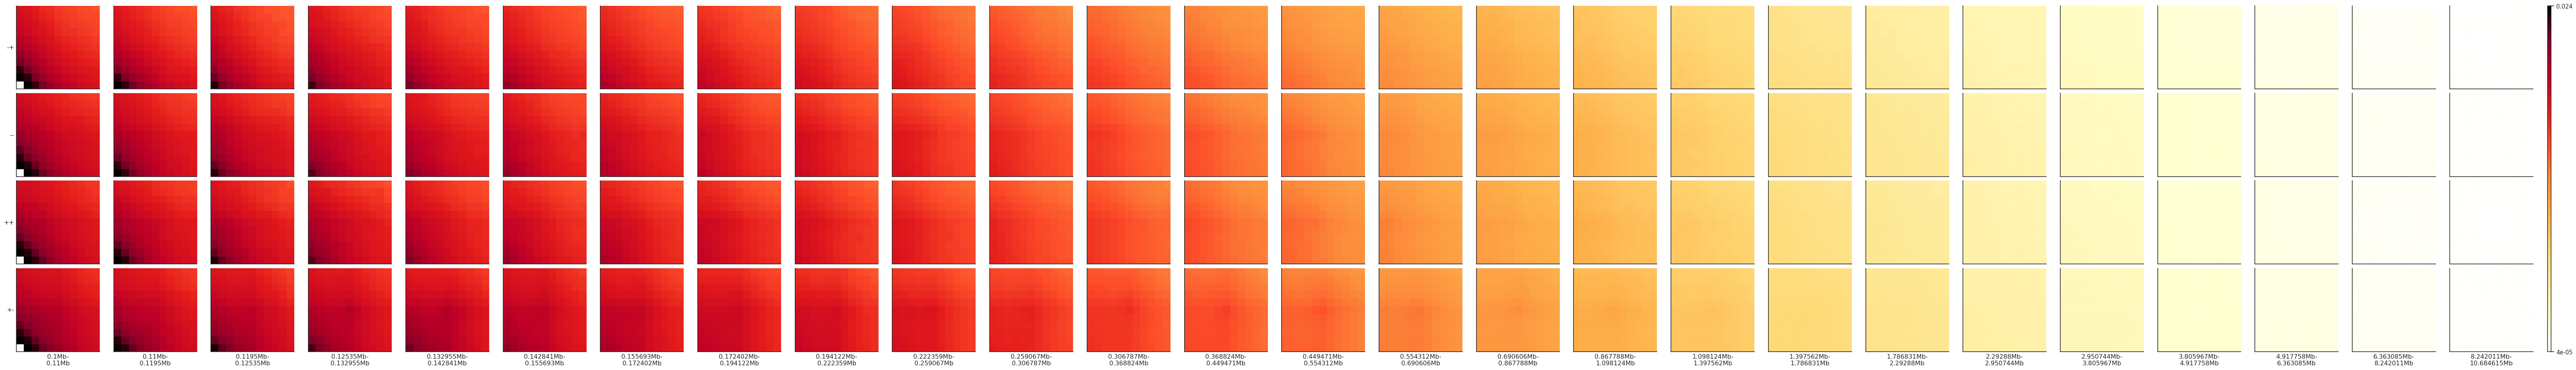

In [17]:
sites = peaks_motifs_bin_s

sample_dict = ['WT']
for sample in sample_dict:
    f = open('../output/scores/experiments/dots_vs_distance_peaks_motifs_%s_Bonev_bin_s.csv'%sample,'w')
    f.write('orientation,dist,peak_score\n')
    clr =  bonev_cooler
    pup = coolpup.pileup(clr, 
                         sites, 
                         features_format='bed', view_df = view_df,
                         flip_negative_strand = True,
                         by_distance = np.array(band_edges),
                         by_strand = True, mindist = mindist, maxdist = maxdist,
                        flank = flank, min_diag = min_diag,
                        nproc = 19
                        )
    for i in range(len(pup['data'])):
        pseudocount = np.mean(np.isfinite(pup['data'][i]))/1000
        score = peak_score(pup['data'][i],3,4,pseudocount)
        if pup['separation'][i] == 'all':
            continue
        
        dist = np.mean(pup['distance_band'][i])
        orientation = pup['orientation'][i]
        f.write('%s,%s,%s\n'%(orientation,dist,score))
    fg = plotpup.plot(pup,  rows = 'orientation',cols = 'separation',
                  row_order = ['-+', '--', '++', '+-'],score = False, 
                  cmap = 'fall', 
                  scale = 'log', sym = False,
                  height = 3)
    
    plt.show()
    f.close()

# Liu et al 

[100000.0, 110000.0, 119500.0, 125350.0, 132955.0, 142841.5, 155693.95, 172402.135, 194122.77550000005, 222359.60815000004, 259067.49059500004, 306787.7377735001, 368824.05910555006, 449471.2768372151, 554312.6598883797, 690606.4578548936, 867788.3952113617, 1098124.9137747702, 1397562.3879072014, 1786831.104279362, 2292880.4355631704, 2950744.566232122, 3805967.9361017584, 4917758.316932286, 6363085.812011973, 8242011.555615564, 10684615.022300234, 13859999.528990304, 17987999.387687396, 23354399.203993615, 30330718.965191703, 39399934.654749215, 51189915.05117398, 66516889.566526175, 86441956.43648404]


INFO:coolpuppy:('chr19', 'chr19'): 98484
INFO:coolpuppy:('chr14', 'chr14'): 120089
INFO:coolpuppy:('chr10', 'chr10'): 153121
INFO:coolpuppy:('chr15', 'chr15'): 145860
INFO:coolpuppy:('chr18', 'chr18'): 80119
INFO:coolpuppy:('chr16', 'chr16'): 102754
INFO:coolpuppy:('chr1', 'chr1'): 201599
INFO:coolpuppy:('chr13', 'chr13'): 130934
INFO:coolpuppy:('chr12', 'chr12'): 122134
INFO:coolpuppy:('chr3', 'chr3'): 130089
INFO:coolpuppy:('chr2', 'chr2'): 267577
INFO:coolpuppy:('chr17', 'chr17'): 158326
INFO:coolpuppy:('chr4', 'chr4'): 257534
INFO:coolpuppy:('chr11', 'chr11'): 315384
INFO:coolpuppy:Total number of piled up windows: 2284004


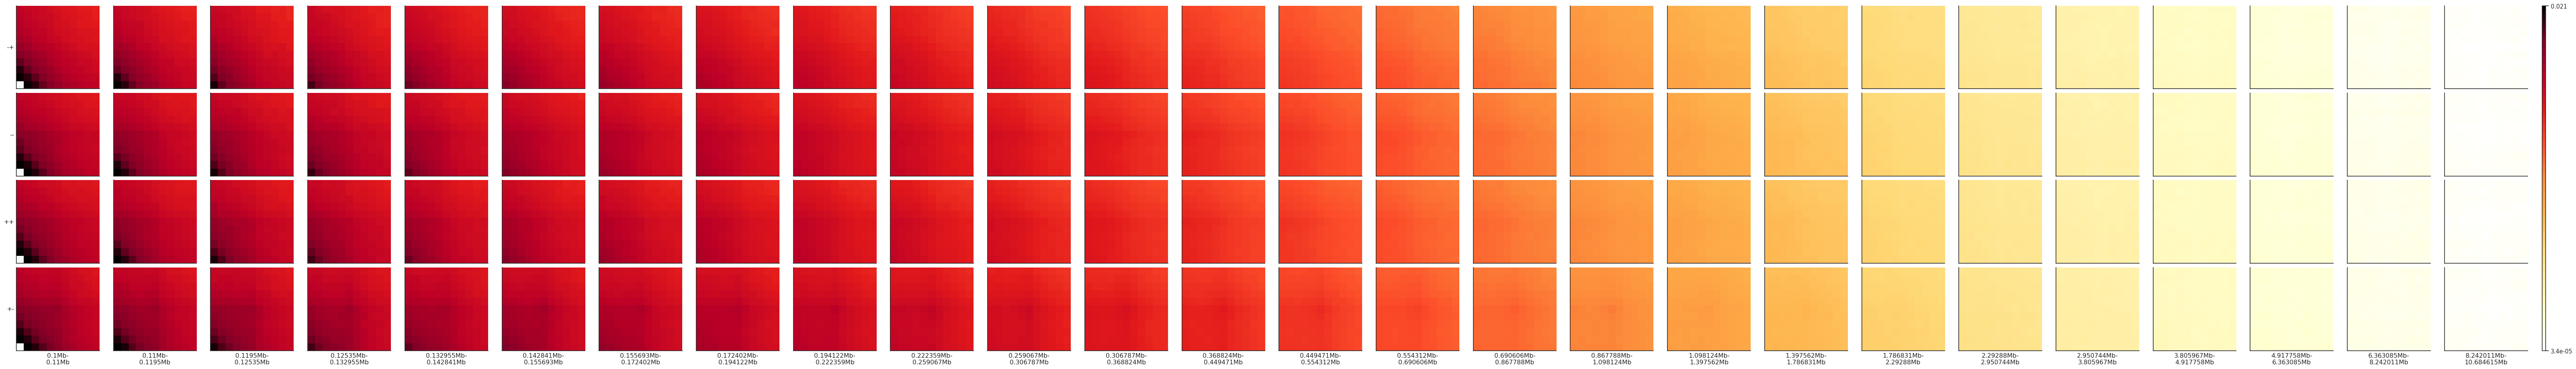

INFO:coolpuppy:('chr18', 'chr18'): 80119
INFO:coolpuppy:('chr16', 'chr16'): 102754
INFO:coolpuppy:('chr14', 'chr14'): 120089
INFO:coolpuppy:('chr15', 'chr15'): 145860
INFO:coolpuppy:('chr19', 'chr19'): 98484
INFO:coolpuppy:('chr3', 'chr3'): 130089
INFO:coolpuppy:('chr17', 'chr17'): 158326
INFO:coolpuppy:('chr12', 'chr12'): 122134
INFO:coolpuppy:('chr13', 'chr13'): 130934
INFO:coolpuppy:('chr4', 'chr4'): 257534
INFO:coolpuppy:('chr10', 'chr10'): 153121
INFO:coolpuppy:('chr1', 'chr1'): 201599
INFO:coolpuppy:('chr2', 'chr2'): 267577
INFO:coolpuppy:('chr11', 'chr11'): 315384
INFO:coolpuppy:Total number of piled up windows: 2284004


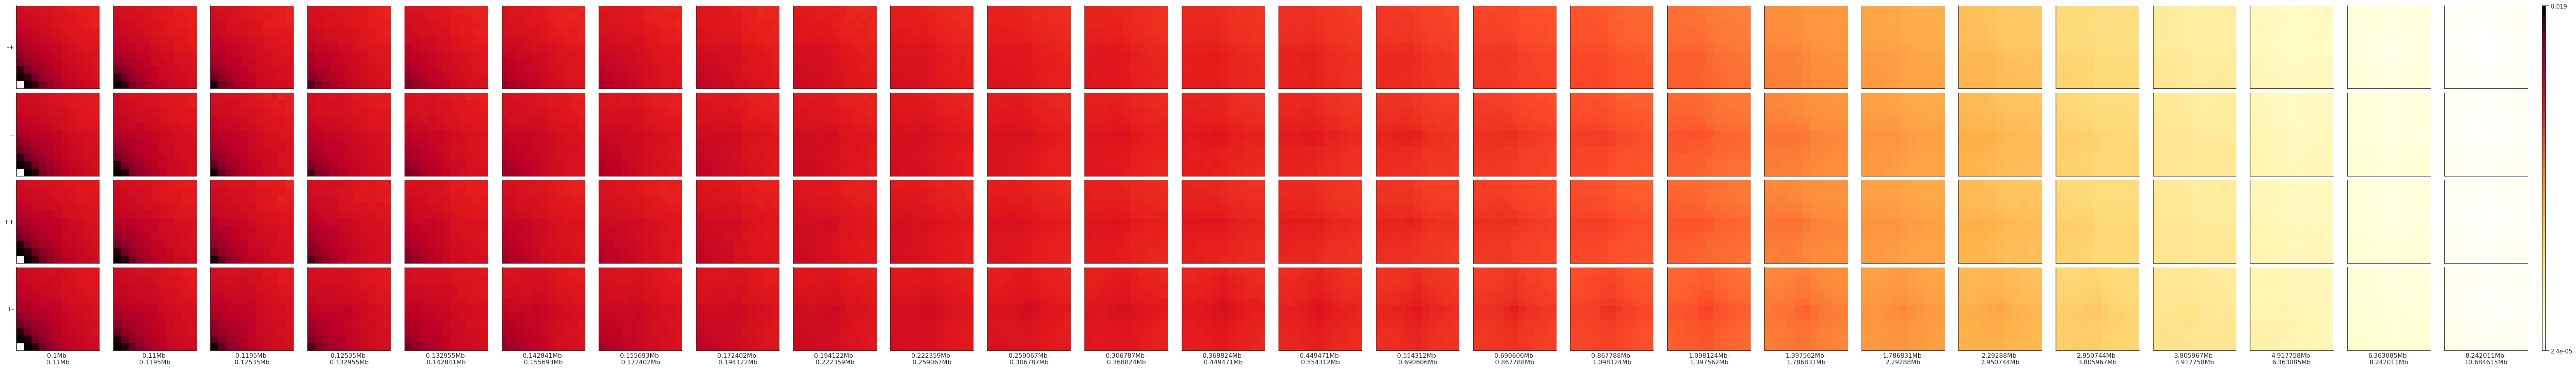

In [33]:
sites=peaks_motifs_bin_s.copy()

sample_dict_liu ={
    'Wapl-0h':'GSM5512837_HiC.01_WAPL_0h.mcool',
    'Wapl-6h':'GSM5512838_HiC.02_WAPL_6h.mcool'
}

mindist = 100_000
for sample in sample_dict_liu:
    f=open('dots_vs_distance_peaks_motifs_%s_Liu_bin_s_pseudo1000.csv'%sample,'w')
    f.write('orientation,dist,n,peak_score\n')
    mcool_path_liu =  cooler_prefix_liu + sample_dict_liu[sample]
    liu_cooler = cooler.Cooler(mcool_path_liu+'::resolutions/'+str(res))
    view_df_liu = cooltools.lib.make_cooler_view(liu_cooler)[:19]
    clr =  liu_cooler
    pup = coolpup.pileup(clr, 
                         sites, 
                         features_format='bed', view_df=view_df_liu[:19],
                         flip_negative_strand=True,
                         by_distance=np.array(band_edges),
                         by_strand=True, mindist=mindist, maxdist=maxdist,
                        flank=flank, min_diag=mindiag,
                        nproc=19
                        )
    for i in range(len(pup['data'])):
        pseudocount = np.mean(np.isfinite(pup['data'][i]))/1000
        score=peak_score(pup['data'][i],3,4,pseudocount)
        if pup['separation'][i]=='all':
            continue
        
        dist=np.mean(pup['distance_band'][i])
        orientation=pup['orientation'][i]
        n = pup['n'][i]
        f.write('%s,%s,%s,%s\n'%(orientation,dist,n,score))
    fg = plotpup.plot(pup,  rows='orientation',cols='separation',
                  row_order=['-+', '--', '++', '+-'],score=False, 
                  cmap='fall', 
                  scale='log', sym=False,
                  height=3)
    
    plt.show()
    f.close()

### Liu et al 2021

[90000.0, 105000.0, 112500.0, 123750.0, 140625.0, 165937.5, 203906.25, 260859.375, 346289.0625, 474433.59375, 666650.390625, 954975.5859375, 1387463.37890625, 2036195.068359375, 3009292.6025390625, 4468938.903808594, 6658408.355712891, 9942612.533569336, 14868918.800354004]


INFO:coolpuppy:('chr18', 'chr18'): 80224
INFO:coolpuppy:('chr19', 'chr19'): 98648
INFO:coolpuppy:('chr16', 'chr16'): 102895
INFO:coolpuppy:('chr14', 'chr14'): 120236
INFO:coolpuppy:('chr12', 'chr12'): 122315
INFO:coolpuppy:('chr3', 'chr3'): 130287
INFO:coolpuppy:('chr15', 'chr15'): 146075
INFO:coolpuppy:('chr13', 'chr13'): 131114
INFO:coolpuppy:('chr10', 'chr10'): 153343
INFO:coolpuppy:('chr17', 'chr17'): 158558
INFO:coolpuppy:('chr8', 'chr8'): 193718
INFO:coolpuppy:('chr1', 'chr1'): 201880
INFO:coolpuppy:('chr6', 'chr6'): 212495
INFO:coolpuppy:('chr9', 'chr9'): 235946
INFO:coolpuppy:('chr7', 'chr7'): 227366
INFO:coolpuppy:('chr4', 'chr4'): 257885
INFO:coolpuppy:('chr2', 'chr2'): 267984
INFO:coolpuppy:('chr11', 'chr11'): 315794
INFO:coolpuppy:('chr5', 'chr5'): 330401
INFO:coolpuppy:Total number of piled up windows: 3487164


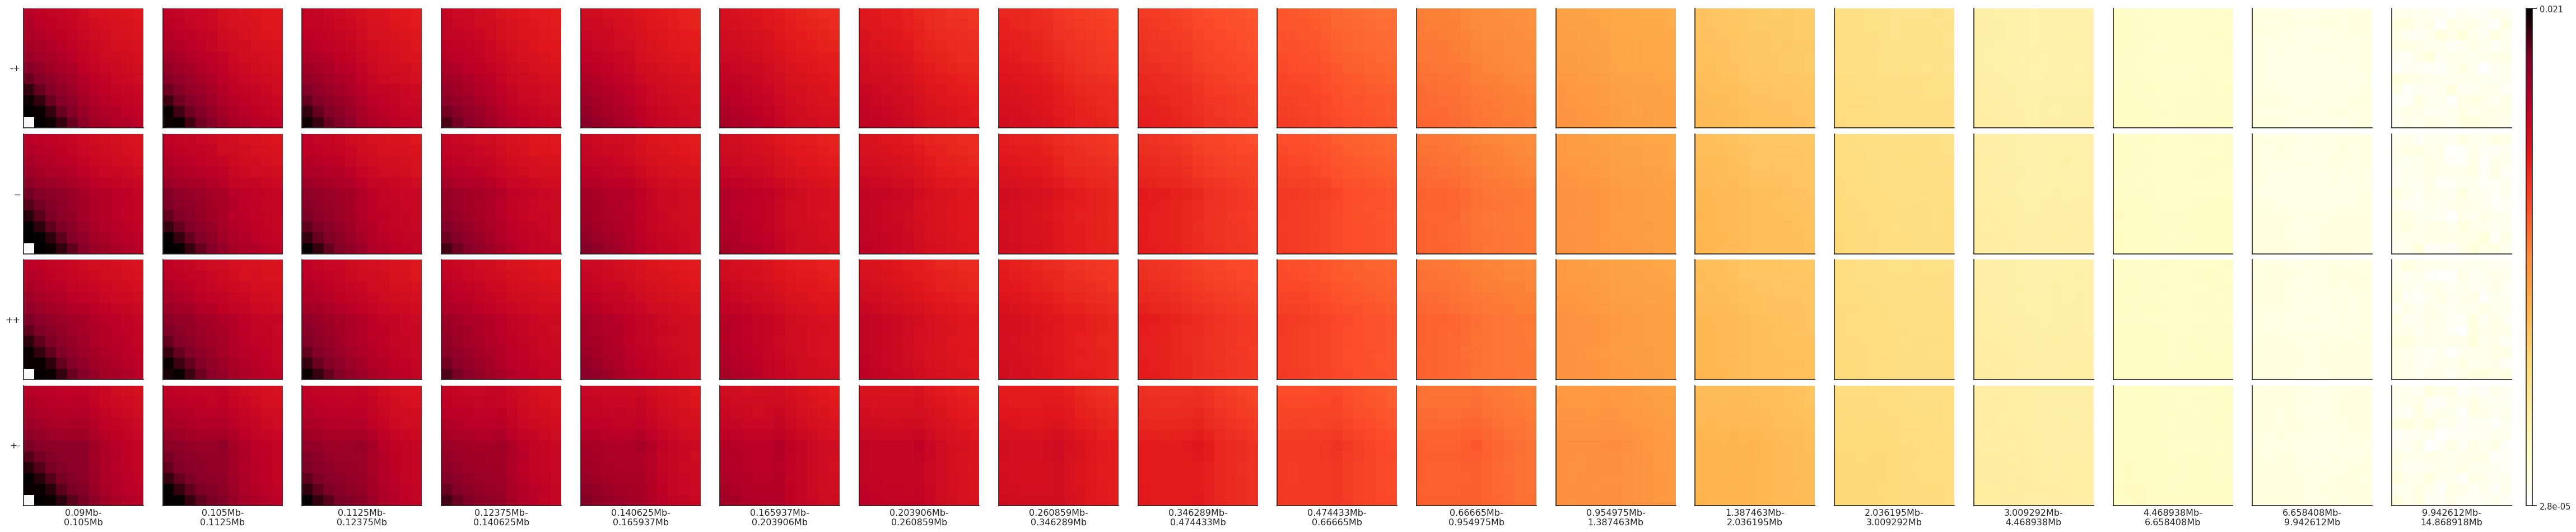

INFO:coolpuppy:('chr18', 'chr18'): 80224
INFO:coolpuppy:('chr19', 'chr19'): 98648
INFO:coolpuppy:('chr16', 'chr16'): 102895
INFO:coolpuppy:('chr14', 'chr14'): 120236
INFO:coolpuppy:('chr12', 'chr12'): 122315
INFO:coolpuppy:('chr3', 'chr3'): 130287
INFO:coolpuppy:('chr13', 'chr13'): 131114
INFO:coolpuppy:('chr15', 'chr15'): 146075
INFO:coolpuppy:('chr10', 'chr10'): 153343
INFO:coolpuppy:('chr17', 'chr17'): 158558
INFO:coolpuppy:('chr8', 'chr8'): 193718
INFO:coolpuppy:('chr1', 'chr1'): 201880
INFO:coolpuppy:('chr6', 'chr6'): 212495
INFO:coolpuppy:('chr7', 'chr7'): 227366
INFO:coolpuppy:('chr9', 'chr9'): 235946
INFO:coolpuppy:('chr4', 'chr4'): 257885
INFO:coolpuppy:('chr2', 'chr2'): 267984
INFO:coolpuppy:('chr11', 'chr11'): 315794
INFO:coolpuppy:('chr5', 'chr5'): 330401
INFO:coolpuppy:Total number of piled up windows: 3487164


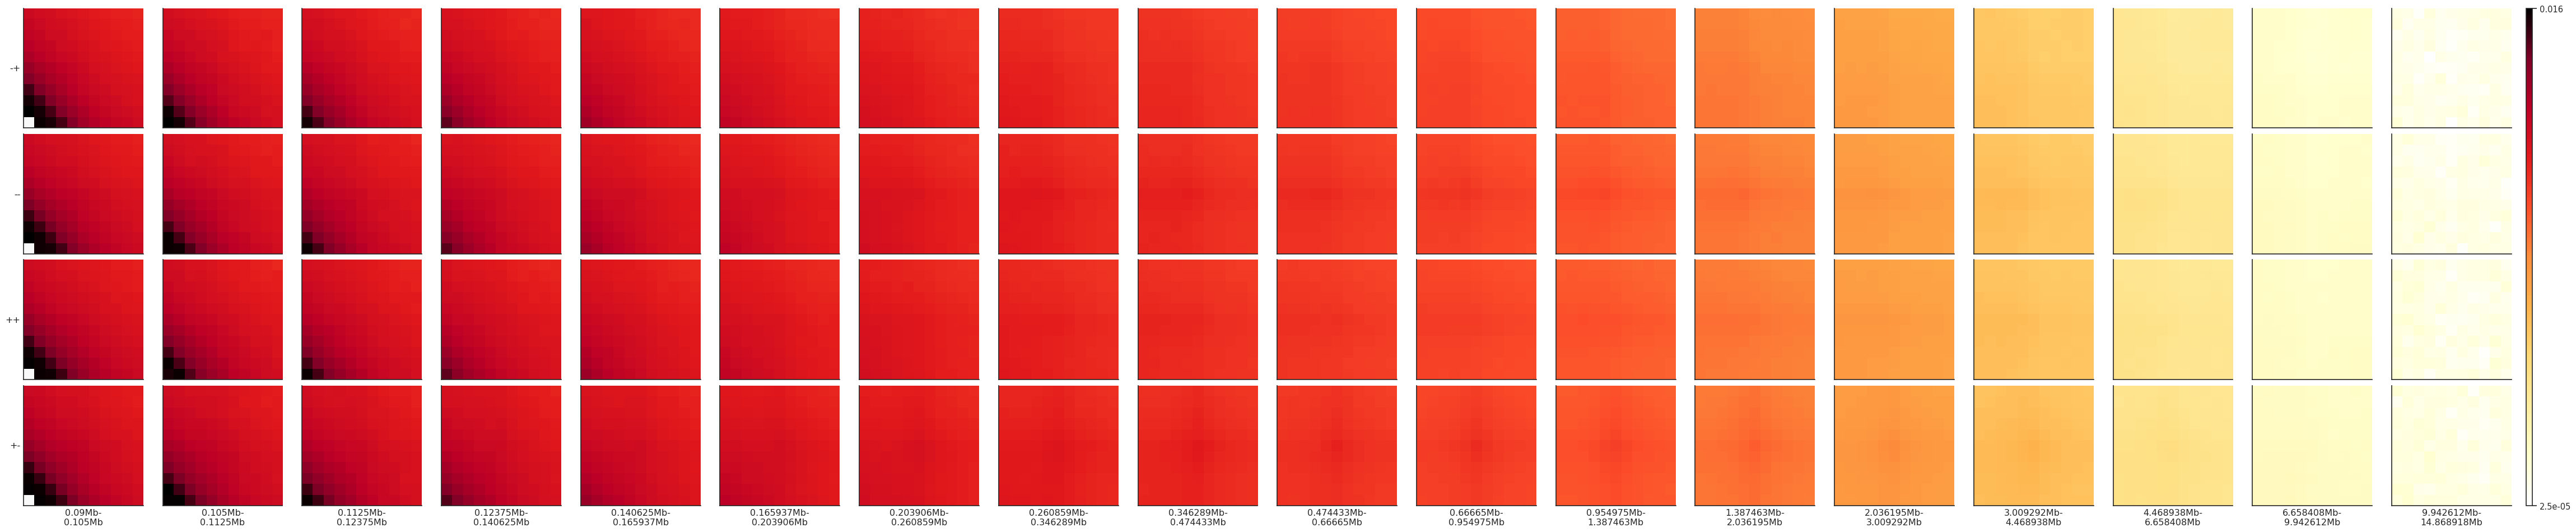

In [40]:
sites=peaks_motifs_bin.copy()


for sample in sample_dict_liu_new:
    f=open('dots_vs_distance_peaks_motifs_%s_Liu_new_bin.csv'%sample,'w')
    f.write('orientation,dist,peak_score\n')
    mcool_path_liu_new =  cooler_prefix_liu_new + sample_dict_liu_new[sample]
    liu_cooler_new = cooler.Cooler(mcool_path_liu_new+'::resolutions/'+str(res))
    view_df_liu_new = cooltools.lib.make_cooler_view(liu_cooler_new)[:19]
    clr =  liu_cooler_new
    pup = coolpup.pileup(clr, 
                         sites, 
                         features_format='bed', view_df=view_df_liu_new[:19],
                         flip_negative_strand=True,
                         by_distance=np.array(band_edges),
                         by_strand=True, mindist=mindist, maxdist=10_000_000,
                        flank=50_000, min_diag=2,
                        nproc=19
                        )
    for i in range(len(pup['data'])):
        pseudocount = np.mean(np.isfinite(pup['data'][i]))/1000
        score=peak_score(pup['data'][i],3,4,pseudocount)
        if pup['separation'][i]=='all':
            continue
            
        dist=np.mean(pup['distance_band'][i])
        orientation=pup['orientation'][i]
        f.write('%s,%s,%s\n'%(orientation,dist,score))
    fg = plotpup.plot(pup,  rows='orientation',cols='separation',
                  row_order=['-+', '--', '++', '+-'],score=False, 
                  cmap='fall', 
                  scale='log', sym=False,
                  height=3)
    
    plt.show()
    f.close()

### peak score vs distance

In [43]:
from scipy.ndimage import gaussian_filter1d
def smooth(x, sigma = 1.95):
        return gaussian_filter1d(x, sigma)

In [20]:
# Bonev et al

WT 1.04991721902135
weight average mean is 1.006858494008707
weight average mean for convergent is 1.0214191793205334


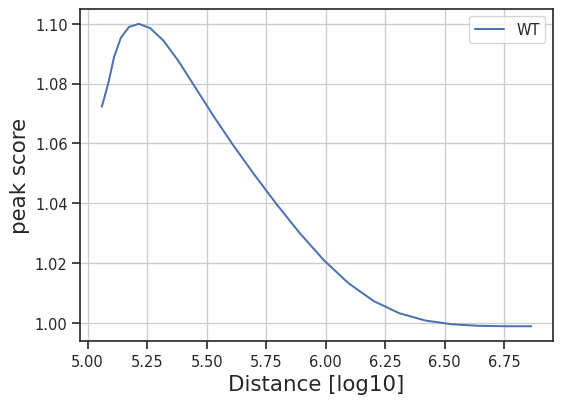

In [44]:
fig, axs = plt.subplots(1, 1, figsize=(6.35, 4.5))  # 3 rows, 1 column

new_sample_dict =['WT']

for name in new_sample_dict[:15]:
    data = pd.read_csv('../output/scores/experiments/experimental_peak_score/dots_vs_distance_peaks_motifs_WT_Bonev_bin_s_Justice.csv')
    data=data[data['dist']<=7500000]
    dist_conv=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    pixel_start=1
    axs.plot(np.log10(dist_conv)[pixel_start:],smooth(score_ave)[pixel_start:],label='%s'%name)
    print(name,np.mean(list(score_ave)[1:]))
    n_tot = data['n'].sum()
    data ['score_mult_n'] = (data['peak_score']*data['n'])
    data_mean_weight = (data['score_mult_n'].sum())/n_tot
    data_conv_wes = data[data['orientation']=='+-']
    n_conv_tot = data_conv_wes['n'].sum()
    data_mean_weight_conv = (data_conv_wes['score_mult_n']).sum()/n_conv_tot

    print('weight average mean is %s'%data_mean_weight)
    print('weight average mean for convergent is %s'%data_mean_weight_conv)
axs.grid(True)
axs.set_xlabel('Distance [log10]', fontsize = 16)
axs.legend(fontsize=11)
axs.set_ylabel('peak score',fontsize = 16)
axs.tick_params(labelsize=11)
axs.tick_params(labelsize=11)
plt.show()


In [22]:
# Liu et al

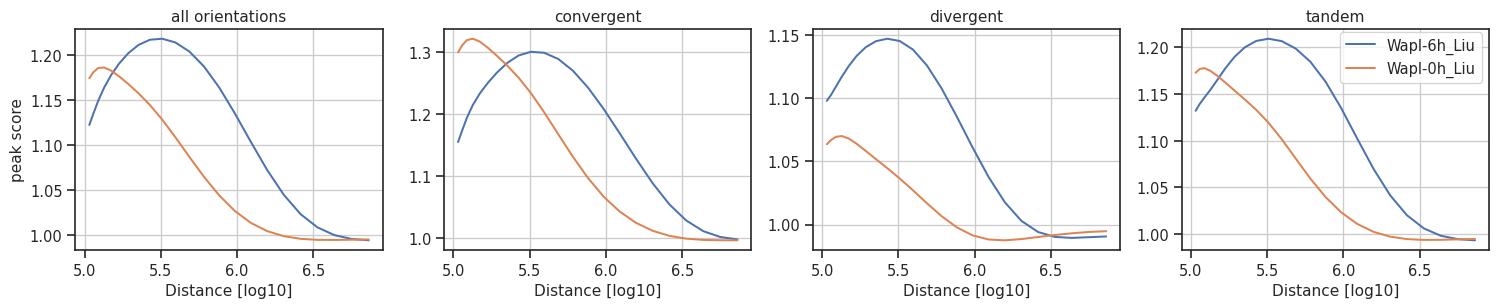

In [45]:
fig, axs = plt.subplots(1, 4, figsize=(19, 3))  # 3 rows, 1 column

new_sample_dict =['Wapl-6h_Liu','Wapl-0h_Liu']#,'WT_Bonev', 'Wapl-0h_new_Liu_','Wapl-24h_new_Liu_']

for name in new_sample_dict[:15]:
    data=pd.read_csv('../output/scores/experiments/experimental_peak_score/dots_vs_distance_peaks_motifs_%s_quartile.csv'%name)
    data = data[data['dist']<=7500000]
    dist=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    score_dive=data[data['orientation']=='-+']['peak_score']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()

    pixel_start = 1
    axs[1].plot(np.log10(dist)[pixel_start:],smooth(score_conv)[pixel_start:],label='%s'%name)
    axs[0].plot(np.log10(dist)[pixel_start:],smooth(score_ave)[pixel_start:],label='%s'%name)
    axs[2].plot(np.log10(dist)[pixel_start:],smooth(score_dive)[pixel_start:],label='%s'%name)
    axs[3].plot(np.log10(dist)[pixel_start:], smooth(score_tandemp)[pixel_start:], label='%s'%name)
plt.xlabel('off-diagonal distance [mb]',fontsize = 11.5)
axs[1].set_title('convergent', fontsize = 11.5)
axs[2].set_title('divergent', fontsize = 11.5)
axs[3].set_title('tandem', fontsize = 11.5)
axs[0].set_title('all orientations', fontsize = 11.5)
for ax in axs:
    ax.grid(True)
    ax.set_xlabel('Distance [log10]', fontsize = 11.5)
axs[3].legend( bbox_to_anchor=(1.0005, 0.87),loc='right')
axs[0].set_ylabel('peak score',fontsize = 11.5)

plt.tight_layout(rect=[10, 10.3, 10.15, 10.95])
plt.show()

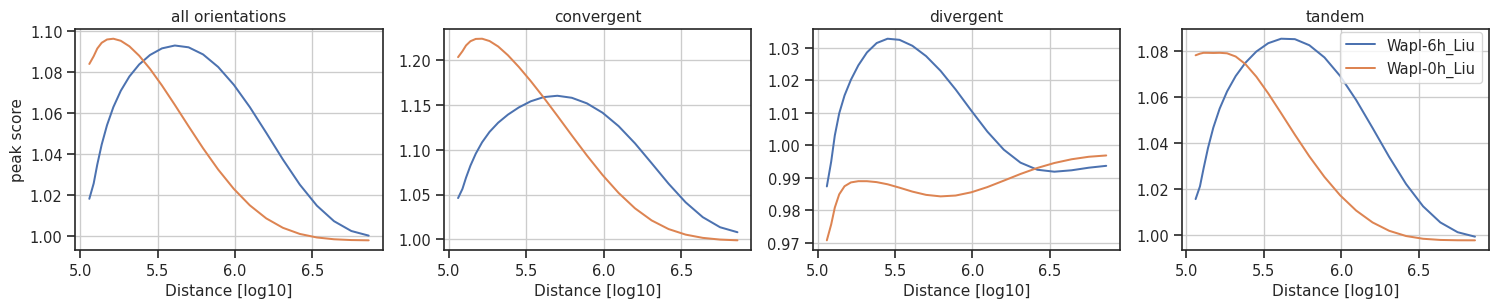

In [46]:
fig, axs = plt.subplots(1, 4, figsize=(19, 3))  # 3 rows, 1 column

new_sample_dict =['Wapl-6h_Liu','Wapl-0h_Liu']#,'WT_Bonev', 'Wapl-0h_new_Liu_','Wapl-24h_new_Liu_']


for name in new_sample_dict[:15]:
    data = pd.read_csv('../output/scores/experiments/experimental_peak_score/dots_vs_distance_peaks_motifs_%s_bin_s_Justice.csv'%name)
    data = data[data['dist']<=7500000]
    dist = data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    score_dive=data[data['orientation']=='-+']['peak_score']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()

    pixel_start = 1
    axs[1].plot(np.log10(dist)[pixel_start:],smooth(score_conv)[pixel_start:],label='%s'%name)
    axs[0].plot(np.log10(dist)[pixel_start:],smooth(score_ave)[pixel_start:],label='%s'%name)
    axs[2].plot(np.log10(dist)[pixel_start:],smooth(score_dive)[pixel_start:],label='%s'%name)
    axs[3].plot(np.log10(dist)[pixel_start:], smooth(score_tandemp)[pixel_start:], label='%s'%name)
#plt.ylabel('Peak score',fontsize = 11.5)
plt.xlabel('off-diagonal distance [mb]',fontsize = 11.5)
axs[1].set_title('convergent', fontsize = 11.5)
axs[2].set_title('divergent', fontsize = 11.5)
axs[3].set_title('tandem', fontsize = 11.5)
axs[0].set_title('all orientations', fontsize = 11.5)
for ax in axs:
    ax.grid(True)
    ax.set_xlabel('Distance [log10]', fontsize = 11.5)
    #ax.set_ylim(0.95,1.35)
axs[3].legend( bbox_to_anchor=(1.0005, 0.87),loc='right')
axs[0].set_ylabel('peak score',fontsize = 11.5)

plt.show()

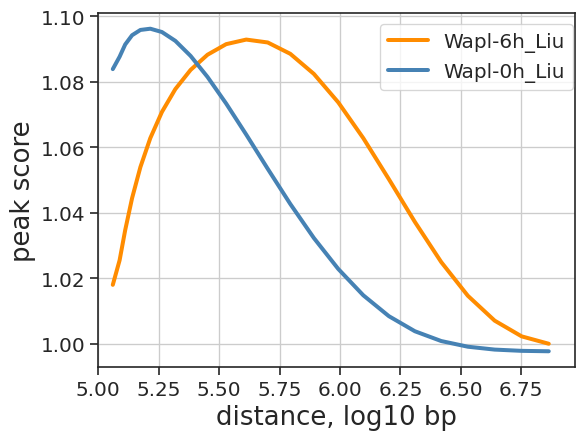

In [47]:
for name in new_sample_dict[:]:
    if name=='Wapl-6h_Liu':
        color='darkorange'
    else: 
        color='steelblue'
    data = pd.read_csv('../output/scores/experiments/experimental_peak_score/dots_vs_distance_peaks_motifs_%s_bin_s_Justice.csv'%name)
    data = data[data['dist']<=7500000]
    dist=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    score_dive=data[data['orientation']=='-+']['peak_score']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    pixel_start =1
    plt.plot(np.log10(dist)[pixel_start:],smooth(score_ave)[pixel_start:],linewidth = 3, color=color,label='%s'%name)
plt.grid(True)
plt.xlim(5,6.97)
plt.xlabel('distance, log10 kb',fontsize=14.5)
plt.ylabel('peak score',fontsize = 14.5)
plt.ylabel('peak score',fontsize = 19.5)
plt.xlabel('distance, log10 bp', fontsize = 19.5)
plt.legend(loc=(0.591,0.781), fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('../output/figures/observed_for_ctcf&motifs_from_papers_bin_all.pdf', bbox_inches = 'tight')
plt.show()

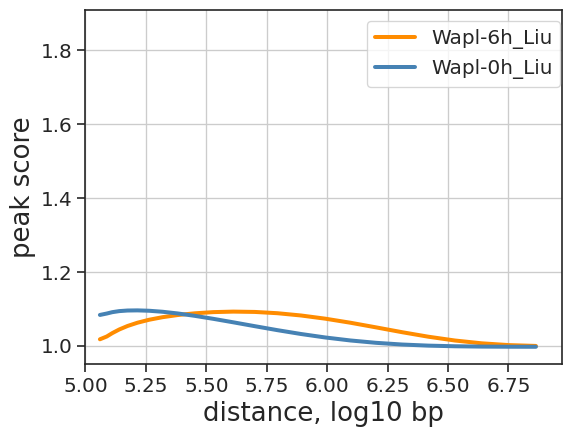

In [48]:
for name in new_sample_dict[:]:
    if name=='Wapl-6h_Liu':
        color='darkorange'
    else: 
        color='steelblue'
    data = pd.read_csv('../output/scores/experiments/experimental_peak_score/dots_vs_distance_peaks_motifs_%s_bin_s_Justice.csv'%name)
    data = data[data['dist']<=7500000]
    dist=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    score_dive=data[data['orientation']=='-+']['peak_score']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    pixel_start =1
    plt.plot(np.log10(dist)[pixel_start:],smooth(score_ave)[pixel_start:],linewidth = 3, color=color,label='%s'%name)
plt.grid(True)
plt.xlim(5,6.97)
plt.ylim(0.95,1.91)
plt.xlabel('distance, log10 kb',fontsize=14.5)
plt.ylabel('peak score',fontsize = 14.5)
plt.ylabel('peak score',fontsize = 19.5)
plt.xlabel('distance, log10 bp', fontsize = 19.5)
plt.legend(loc=(0.591,0.781), fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('../output/figures/observed_for_ctcf&motifs_from_papers_bin_all_mag.pdf', bbox_inches = 'tight')
plt.show()

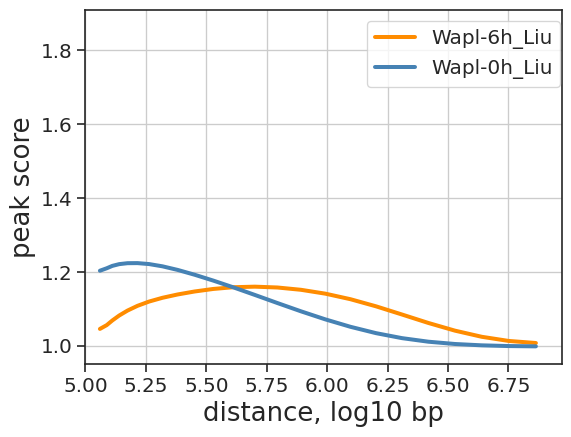

In [49]:
for name in new_sample_dict[:]:
    if name=='Wapl-6h_Liu':
        color='darkorange'
    else: 
        color='steelblue'
    data = pd.read_csv('../output/scores/experiments/experimental_peak_score/dots_vs_distance_peaks_motifs_%s_bin_s_Justice.csv'%name)
    data = data[data['dist']<=7500000]
    dist=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    score_dive=data[data['orientation']=='-+']['peak_score']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    pixel_start =1
    plt.plot(np.log10(dist)[pixel_start:],smooth(score_conv)[pixel_start:],linewidth = 3, color=color,label='%s'%name)
plt.grid(True)
plt.xlim(5,6.97)
plt.ylim(0.95,1.91)
plt.xlabel('distance, log10 kb',fontsize=14.5)
plt.ylabel('peak score',fontsize = 14.5)
plt.ylabel('peak score',fontsize = 19.5)
plt.xlabel('distance, log10 bp', fontsize = 19.5)
plt.legend(loc=(0.591,0.781), fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('../output/observed_for_ctcf&motifs_from_papers_bin_sconv_mag.pdf', bbox_inches = 'tight')
plt.show()

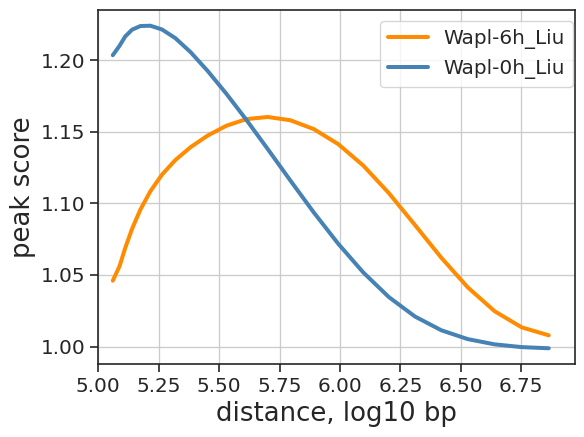

In [50]:
for name in new_sample_dict[:]:
    if name=='Wapl-6h_Liu':
        color='darkorange'
    else: 
        color='steelblue'
    data = pd.read_csv('../output/scores/experiments/experimental_peak_score/dots_vs_distance_peaks_motifs_%s_bin_s_Justice.csv'%name)
    data = data[data['dist']<=7500000]
    dist=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    score_dive=data[data['orientation']=='-+']['peak_score']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    pixel_start =1
    plt.plot(np.log10(dist)[pixel_start:],smooth(score_conv)[pixel_start:],linewidth = 3, color=color,label='%s'%name)
plt.grid(True)
plt.xlim(5,6.97)
#plt.ylim(0.95,1.91)
plt.xlabel('distance, log10 kb',fontsize=14.5)
plt.ylabel('peak score',fontsize = 14.5)
plt.ylabel('peak score',fontsize = 19.5)
plt.xlabel('distance, log10 bp', fontsize = 19.5)
plt.legend(loc=(0.591,0.781), fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('../output/observed_for_ctcf&motifs_from_papers_bin_sconv.pdf', bbox_inches = 'tight')
plt.show()

Wapl-6h_Liu 1.053883092891853
weight average mean is 1.021790374277569
weight average mean for convergent is 1.0491949753408962
Wapl-0h_Liu 1.05099618472769
weight average mean is 1.0066877625275277
weight average mean for convergent is 1.0233434710016294


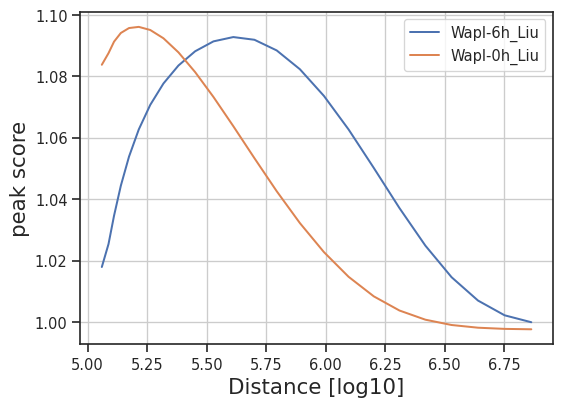

In [51]:
fig, axs = plt.subplots(1, 1, figsize=(6.35, 4.5))  # 3 rows, 1 column

new_sample_dict =['Wapl-6h_Liu','Wapl-0h_Liu',]


for name in new_sample_dict[:15]:
    data = pd.read_csv('../output/scores/experiments/experimental_peak_score/dots_vs_distance_peaks_motifs_%s_bin_s_Justice.csv'%name)
    data=data[data['dist']<=7500000]
    dist=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    score_dive=data[data['orientation']=='-+']['peak_score']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    
    pixel_start=1
    axs.plot(np.log10(dist)[pixel_start:],smooth(score_ave)[pixel_start:],label='%s'%name)
    print(name,np.mean(list(score_ave)[1:]))
    n_tot = data['n'].sum()
    data ['score_mult_n'] = (data['peak_score']*data['n'])
    data_mean_weight = (data['score_mult_n'].sum())/n_tot
    data_conv_wes = data[data['orientation']=='+-']
    n_conv_tot = data_conv_wes['n'].sum()
    data_mean_weight_conv = (data_conv_wes['score_mult_n']).sum()/n_conv_tot
    
    #data_mean_weight
    print('weight average mean is %s'%data_mean_weight)
    print('weight average mean for convergent is %s'%data_mean_weight_conv)

axs.grid(True)
axs.set_xlabel('Distance [log10]', fontsize = 16)
axs.legend(fontsize=11)
axs.set_ylabel('peak score',fontsize = 16)
axs.tick_params(labelsize=11)
axs.tick_params(labelsize=11)
plt.show()

Wapl-6h_Liu 1.053883092891853
weight average mean is 1.021790374277569
weight average mean for convergent is 1.0491949753408962
Wapl-0h_Liu 1.05099618472769
weight average mean is 1.0066877625275277
weight average mean for convergent is 1.0233434710016294


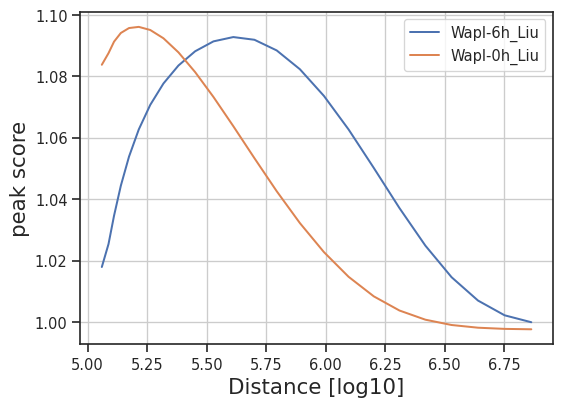

In [53]:
fig, axs = plt.subplots(1, 1, figsize=(6.35, 4.5))  # 3 rows, 1 column

new_sample_dict =['Wapl-6h_Liu','Wapl-0h_Liu',]


for name in new_sample_dict[:15]:
    data = pd.read_csv('../output/scores/experiments/experimental_peak_score/dots_vs_distance_peaks_motifs_%s_bin_s_Justice.csv'%name)
    data=data[data['dist']<=7500000]
    dist=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    score_dive=data[data['orientation']=='-+']['peak_score']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    
    pixel_start=1
    axs.plot(np.log10(dist)[pixel_start:],smooth(score_ave)[pixel_start:],label='%s'%name)
    print(name,np.mean(list(score_ave)[1:]))
    n_tot = data['n'].sum()
    data ['score_mult_n'] = (data['peak_score']*data['n'])
    data_mean_weight = (data['score_mult_n'].sum())/n_tot
    data_conv_wes = data[data['orientation']=='+-']
    n_conv_tot = data_conv_wes['n'].sum()
    data_mean_weight_conv = (data_conv_wes['score_mult_n']).sum()/n_conv_tot
    
    #data_mean_weight
    print('weight average mean is %s'%data_mean_weight)
    print('weight average mean for convergent is %s'%data_mean_weight_conv)
axs.grid(True)
axs.set_xlabel('Distance [log10]', fontsize = 16)
axs.legend(fontsize=11)
axs.set_ylabel('peak score',fontsize = 16)
axs.tick_params(labelsize=11)
axs.tick_params(labelsize=11)
plt.show()

In [54]:
# Liu et al new

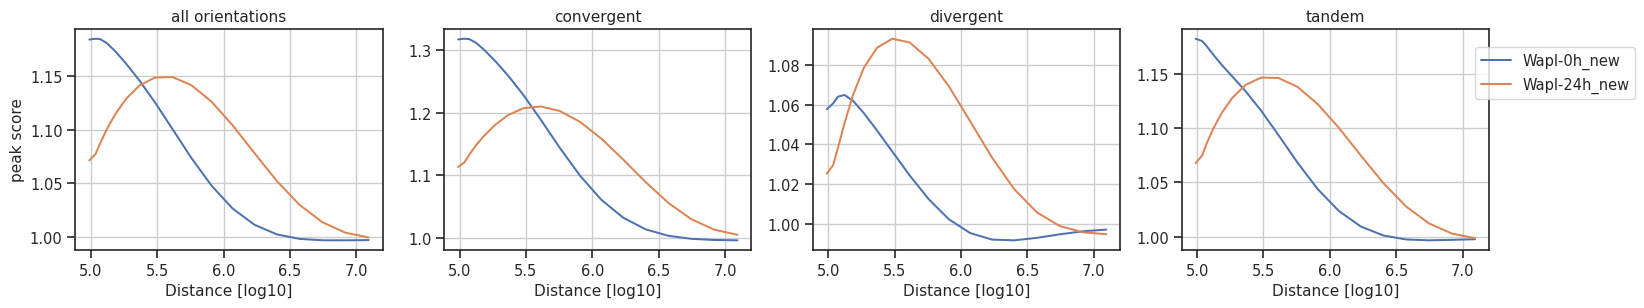

In [55]:
fig, axs = plt.subplots(1, 4, figsize=(19, 3))  # 3 rows, 1 column

new_sample_dict =['Wapl-0h_new','Wapl-24h_new']#,'WT_Bonev', 'Wapl-0h_new_Liu_','Wapl-24h_new_Liu_']

sample_dict_liu_new ={
    'Wapl-0h_new':'liu_wapl0h.mm10.mapq_30.1000.mcool',
    'Wapl-24h_new':'liu_wapl24h.mm10.mapq_30.1000.mcool'
}

for name in new_sample_dict[:15]:
    data=pd.read_csv('../output/scores/experiments/experimental_peak_score/dots_vs_distance_peaks_motifs_%s_Liu_new_quartile.csv'%name)
    dist=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    score_dive=data[data['orientation']=='-+']['peak_score']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    axs[1].plot(np.log10(dist),smooth(score_conv),label='%s'%name)
    axs[0].plot(np.log10(dist),smooth(score_ave),label='%s'%name)
    axs[2].plot(np.log10(dist),smooth(score_dive),label='%s'%name)
    axs[3].plot(np.log10(dist), smooth(score_tandemp), label='%s'%name)
#plt.ylabel('Peak score',fontsize = 11.5)
plt.xlabel('off-diagonal distance [mb]',fontsize = 11.5)
axs[1].set_title('convergent', fontsize = 11.5)
axs[2].set_title('divergent', fontsize = 11.5)
axs[3].set_title('tandem', fontsize = 11.5)
axs[0].set_title('all orientations', fontsize = 11.5)
for ax in axs:
    ax.grid(True)
    ax.set_xlabel('Distance [log10]', fontsize = 11.5)
axs[3].legend( bbox_to_anchor=(1.5, 0.8),loc='right')
axs[0].set_ylabel('peak score',fontsize = 11.5)

plt.tight_layout(rect=[10, 10.3, 10.15, 10.95])
plt.savefig('../output/figures/observed_for_ctcf&motifs_from_papers.png', bbox_inches = 'tight')
plt.show()